In [1]:
from __future__ import print_function
%matplotlib inline
import os
from collections import OrderedDict
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from sklearn.metrics import classification_report
from skimage.util import random_noise
import decimal
import captum
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import pandas as pd
import datetime
import random
from IPython.display import clear_output
from dateutil.parser import parse
from random import randrange
from statistics import mean
import seaborn as sns
import sys
import pickle
import math
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/")
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/adunetae")
import utils
from model import Generator,Discriminator
from utils import weights_init,gradient_penalty,normalize
import pdb
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import norm

In [2]:
batch_size = 256
outpath = '/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/adunetae/'
device = torch.device("cuda:3" if (torch.cuda.is_available()) else "cpu")

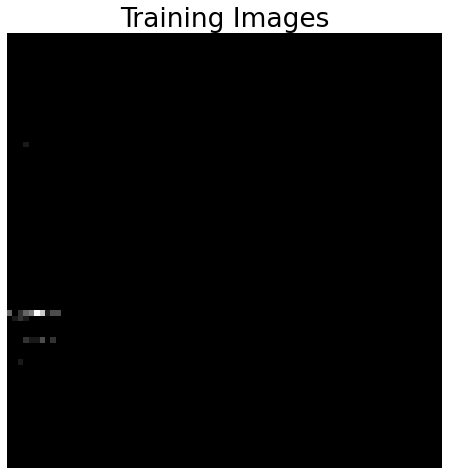

In [3]:
test = np.load('/home/rgopikrishna/data/noisereduced/test_0005.npy')
val = np.load('/home/rgopikrishna/data/noisereduced/val_0005.npy')
train = np.load('/home/rgopikrishna/data/noisereduced/train_0005.npy')

dataloader_test = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False)
dataloader_val = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False)
dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                         shuffle=False)


# Decide which device we want to run on


# Plot some training images
real_batch = next(iter(dataloader_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0,0], padding=2,normalize=True).cpu(),(1,2,0)))

In [4]:
blankwithmikeanomalies = np.load('/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/anomalyfiles/blankwithmikeanomaly_together.npy')

In [5]:
minmax = np.load('/home/rgopikrishna/data/noisereduced/minmax_0005.npy')

In [6]:
netG = Generator().to(device)
netG.load_state_dict(torch.load(outpath + '/models/g_fm_2021-10-05_p0005.pth'))
netG.eval()

Generator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(65, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv6): Conv2d(128, 32, kernel_size=(2, 2), stride

In [7]:
netD = Discriminator().to(device)
netD.load_state_dict(torch.load(outpath + '/models/d_fm_2021-10-05_p0005.pth'))
netD.eval()

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv4): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)

0it [00:00, ?it/s]

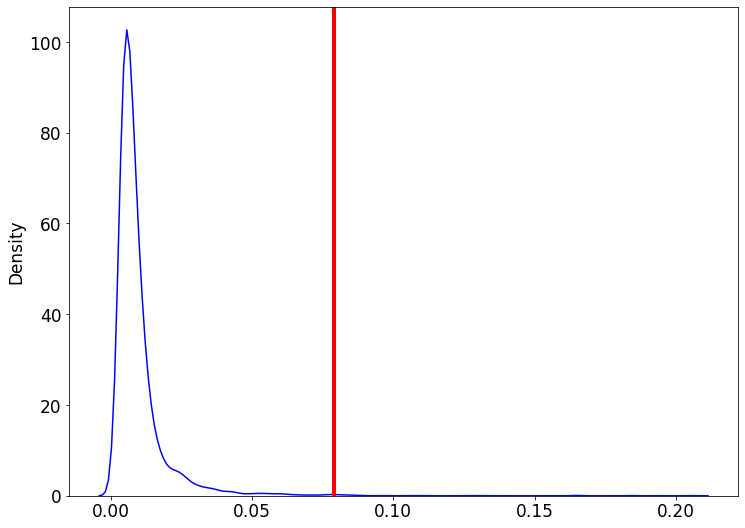

In [47]:
val_scores = []
val_dxs = []

for i, data in tqdm(enumerate(dataloader_val)):
    
    dataBatchX = Variable(data[:,0,:].unsqueeze(1).float()).to(device)
    b_size = dataBatchX.size(0)
    label_real = torch.full((b_size,), 0, dtype=torch.float)
    
    rec_image = netG(torch.randn(dataBatchX.size(0),1, 10, 10, device=device),dataBatchX)

    df_x ,d_x = netD(dataBatchX)
    df_gx,d_gx = netD(rec_image)

    score = ((d_gx.reshape(b_size, -1) - d_x.reshape(b_size, -1))**2).mean(dim=1)
    val_scores.append(score.cpu().data.numpy())
    val_dxs.append(d_x.reshape(b_size, -1).cpu().data.numpy())

val_dxs = np.concatenate(val_dxs)
val_scores = np.sort(np.concatenate(val_scores))[::-1]
threshold = 1.1*val_scores[int((len(val_scores)*0.005))]

fig,ax=plt.subplots(1,1,figsize=(12,9))
sns.kdeplot(val_scores,color='b',label="")
ax.axvline(x=threshold,linewidth=4, color='r')

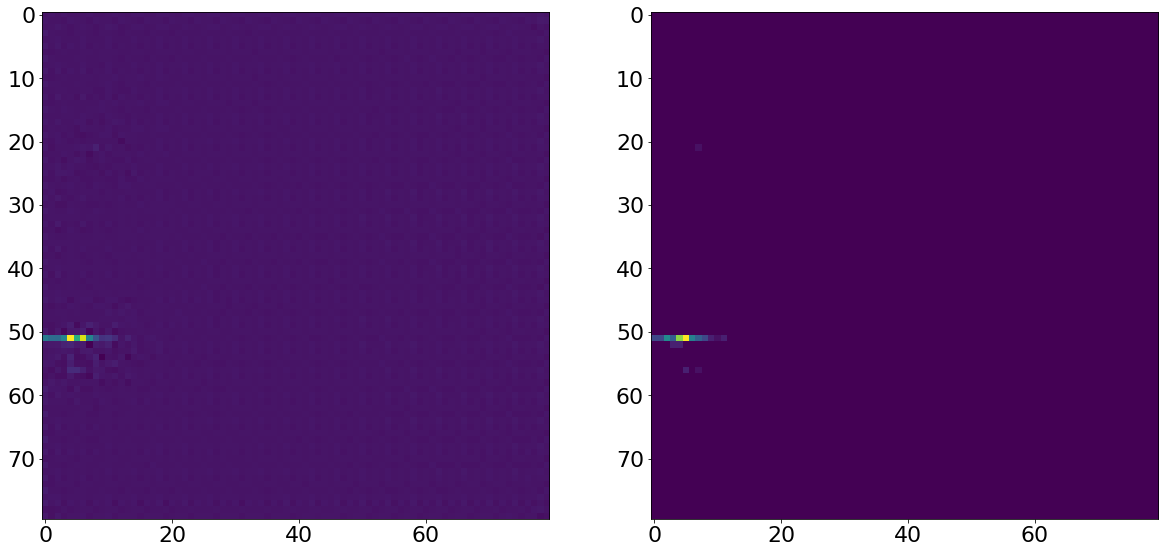

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(rec_image[0,0].cpu().data.numpy())
ax[1].imshow(dataBatchX[0,0].cpu().data.numpy())

In [10]:
d_x.shape,d_gx.shape

(torch.Size([110400]), torch.Size([110400]))

(array([  847.,  1374.,  1267.,  3490., 73831., 26152.,  1980.,  1035.,
          275.,   149.]),
 array([-38.359947 , -30.559387 , -22.758827 , -14.958267 ,  -7.157707 ,
          0.6428528,   8.443413 ,  16.243973 ,  24.044533 ,  31.845093 ,
         39.645653 ], dtype=float32),
 <BarContainer object of 10 artists>)

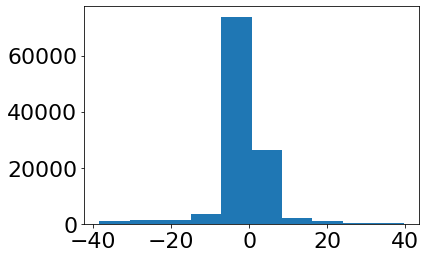

In [11]:
plt.hist(d_x.cpu().data.numpy())

(array([  849.,  1363.,  1273.,  3495., 72330., 27505.,  2094.,  1053.,
          283.,   155.]),
 array([-38.393936 , -30.605177 , -22.81642  , -15.02766  ,  -7.238902 ,
          0.5498562,   8.338614 ,  16.127373 ,  23.916132 ,  31.70489  ,
         39.49365  ], dtype=float32),
 <BarContainer object of 10 artists>)

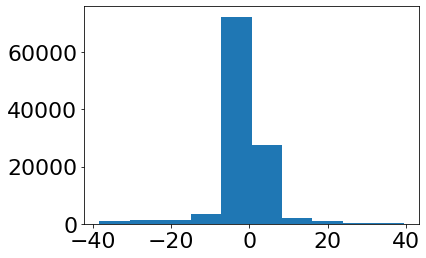

In [12]:
plt.hist(d_gx.cpu().data.numpy())

In [13]:
rec_image[0,0].max(),dataBatchX[0,0].max()

(tensor(0.2107, device='cuda:3', grad_fn=<MaxBackward1>),
 tensor(0.2347, device='cuda:3'))

(array([4.662e+03, 2.560e+02, 5.100e+01, 2.000e+01, 5.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([0.00197353, 0.0226739 , 0.04337427, 0.06407464, 0.08477502,
        0.10547538, 0.12617576, 0.14687613, 0.16757649, 0.18827687,
        0.20897724], dtype=float32),
 <BarContainer object of 10 artists>)

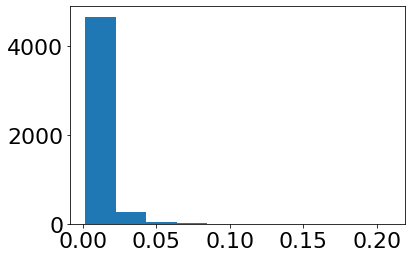

In [14]:
plt.hist(val_scores)

In [15]:
with open(outpath + '/scores/valscores_{}.pkl'.format(str(datetime.date.today())),'wb') as f:
    pickle.dump(val_scores,f)

0it [00:00, ?it/s]

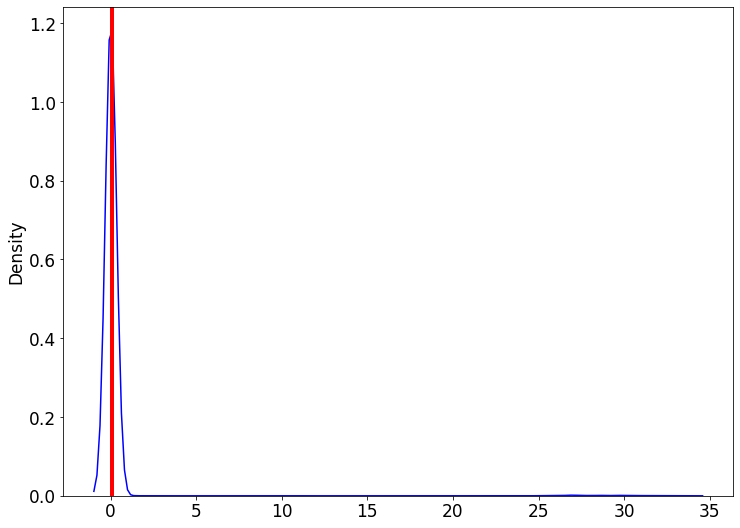

In [48]:
# train_scores = []
# train_dxs = []

# for i, data in tqdm(enumerate(dataloader_train)):
    
#     dataBatchX = Variable(data[:,0,:].unsqueeze(1).float()).to(device)
#     b_size = dataBatchX.size(0)
#     label_real = torch.full((b_size,), 0, dtype=torch.float)
    
#     rec_image = netG(dataBatchX)

#     d_x,_ = netD(dataBatchX)
#     d_gx,_ = netD(rec_image)

#     score = ((d_gx.reshape(b_size, -1) - d_x.reshape(b_size, -1))**2).mean(dim=1)
#     train_scores.append(score.cpu().data.numpy())
#     train_dxs.append(d_x.reshape(b_size, -1).cpu().data.numpy())

# train_dxs = np.concatenate(train_dxs)
# # train_dxs = train_dxs[train_dxs<]
# train_scores = np.sort(np.concatenate(train_scores))[::-1]

train_scores = []
train_dxs = []

for i, data in tqdm(enumerate(dataloader_train)):
    
    dataBatchX = Variable(data[:,0,:].unsqueeze(1).float()).to(device)
    b_size = dataBatchX.size(0)
    label_real = torch.full((b_size,), 0, dtype=torch.float)
    
    rec_image = netG(torch.randn(dataBatchX.size(0),1, 10, 10, device=device),dataBatchX)

    df_x ,d_x = netD(dataBatchX)
    df_gx,d_gx = netD(rec_image)

    score = ((d_gx.reshape(b_size, -1) - d_x.reshape(b_size, -1))**2).mean(dim=1)
    train_scores.append(score.cpu().data.numpy())
    train_dxs.append(d_x.reshape(b_size, -1).cpu().data.numpy())

train_dxs = np.concatenate(train_dxs)
train_scores = np.sort(np.concatenate(train_scores))[::-1]

fig,ax=plt.subplots(1,1,figsize=(12,9))
sns.kdeplot(train_scores,color='b',label="")
ax.axvline(x=threshold,linewidth=4, color='r')

(array([1.1604e+04, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.3000e+01, 3.7000e+01, 1.3000e+01]),
 array([2.22836318e-03, 3.36509109e+00, 6.72795391e+00, 1.00908165e+01,
        1.34536791e+01, 1.68165417e+01, 2.01794052e+01, 2.35422668e+01,
        2.69051304e+01, 3.02679920e+01, 3.36308556e+01], dtype=float32),
 <BarContainer object of 10 artists>)

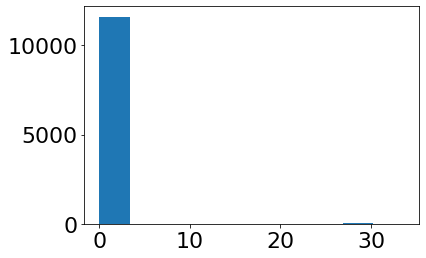

In [17]:
plt.hist(train_scores)

In [18]:
scores = []
labels = []
testdata = []
d_xs = []
d_gxs = []
df_xs = []
df_gxs = []

for i, data in tqdm(enumerate(dataloader_test)):
    
    # no anomalies
    dataBatchX = Variable(data[:,0,:].unsqueeze(1).float()).to(device)
    b_size = dataBatchX.size(0)
    label_real = torch.full((b_size,), 0, dtype=torch.float)
    
    anom1BatchX = torch.rot90(dataBatchX,k=1,dims=[2,3]).to(device)
    label_anom1 = torch.full((b_size,), 1, dtype=torch.float)
    
    anom2BatchX = Variable(anom1BatchX.detach() + dataBatchX.detach()).to(device)
    label_anom2 = torch.full((b_size,), 2, dtype=torch.float)
    
    anom3BatchX = Variable(torch.tensor(random_noise(dataBatchX.detach().cpu(), mode='gaussian', mean=0, var=0.00005, clip=True))).float().to(device)
    label_anom3 = torch.full((b_size,), 3, dtype=torch.float)
    
    blank1 = Variable(torch.zeros(dataBatchX.shape)).float().to(device)
    noise_3 = utils.randomnoise(blank1,dataBatchX.min().detach(),dataBatchX.max().detach(),40,79,0.90,1)
    anom4BatchX = Variable(noise_3.detach() + dataBatchX.detach()).to(device)
    label_anom4 = torch.full((b_size,), 4, dtype=torch.float)
    
    blank2 = Variable(torch.zeros(dataBatchX.shape)).float().to(device)
    noise_1 = utils.randomnoise(blank2,dataBatchX.min().detach(),dataBatchX.max().detach(),40,79,0.95,0.25)
    anom5BatchX = Variable(noise_1.detach() + dataBatchX.detach()).to(device)
    label_anom5 = torch.full((b_size,), 5, dtype=torch.float)
    
    blank3 = Variable(torch.zeros(dataBatchX.shape)).float().to(device)
    noise_2 = utils.randomnoise(blank3,dataBatchX.min().detach(),dataBatchX.max().detach()+1,40,45,0.90,1)
    anom6BatchX = Variable(noise_2.detach() + dataBatchX.detach()).to(device)
    label_anom6 = torch.full((b_size,), 6, dtype=torch.float)
    
    mikeanom = torch.tensor(normalize(blankwithmikeanomalies[random.randrange(len(blankwithmikeanomalies))],minmax[0],minmax[1])).unsqueeze(0).float().to(device).repeat(b_size,1,1).unsqueeze(1)
    mikeanom_1 = torch.tensor(normalize(blankwithmikeanomalies[0],minmax[0],minmax[1])).unsqueeze(0).float().to(device).repeat(b_size,1,1).unsqueeze(1)
    mikeanom_2 = torch.tensor(normalize(blankwithmikeanomalies[1],minmax[0],minmax[1])).unsqueeze(0).float().to(device).repeat(b_size,1,1).unsqueeze(1)
    
    realanom1_BatchX_1 = Variable(1*mikeanom_1.detach() + dataBatchX.detach()).to(device)
    label_realanom1_1 = torch.full((b_size,), 701, dtype=torch.float)
    
    realanom1_BatchX = Variable(1*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom1_ = torch.full((b_size,), 71, dtype=torch.float)
    
    realanom2_BatchX = Variable(2*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom2_ = torch.full((b_size,), 72, dtype=torch.float)
    
    realanom3_BatchX = Variable(3*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom3_ = torch.full((b_size,), 73, dtype=torch.float)
    
    realanom4_BatchX = Variable(4*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom4_ = torch.full((b_size,), 74, dtype=torch.float)
    
    realanom5_BatchX = Variable(5*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom5_ = torch.full((b_size,), 75, dtype=torch.float)
    
    realanom6_BatchX = Variable(6*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom6_ = torch.full((b_size,), 76, dtype=torch.float)
    
    realanom7_BatchX = Variable(7*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom7_ = torch.full((b_size,), 77, dtype=torch.float)
    
    realanom8_BatchX = Variable(8*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom8_ = torch.full((b_size,), 78, dtype=torch.float)
    
    realanom9_BatchX = Variable(9*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom9_ = torch.full((b_size,), 79, dtype=torch.float)
    
    realanom10_BatchX = Variable(10*mikeanom_2.detach() + dataBatchX.detach()).to(device)
    label_realanom10_ = torch.full((b_size,), 710, dtype=torch.float)

    
    for data_ in [(dataBatchX,label_real),(anom1BatchX,label_anom1),(anom2BatchX,label_anom2),
                  (anom3BatchX,label_anom3),(anom4BatchX,label_anom4),(anom5BatchX,label_anom5),
                  (anom6BatchX,label_anom6),(realanom1_BatchX,label_realanom1_),(realanom2_BatchX,label_realanom2_),(realanom3_BatchX,label_realanom3_),(realanom4_BatchX,label_realanom4_),(realanom5_BatchX,label_realanom5_),
                 (realanom6_BatchX,label_realanom6_),(realanom7_BatchX,label_realanom7_),(realanom8_BatchX,label_realanom8_),(realanom9_BatchX,label_realanom9_),(realanom10_BatchX,label_realanom10_),(realanom1_BatchX_1,label_realanom1_1)]:
        
        rec_image = netG(torch.randn(dataBatchX.size(0),1, 10, 10, device=device),data_[0])

        df_x,d_x = netD(data_[0])
        df_gx,d_gx = netD(rec_image)
        
        df_xs.append(df_x.reshape(b_size, -1).cpu().data.numpy())
        df_gxs.append(df_gx.reshape(b_size, -1).cpu().data.numpy())
        
        d_xs.append(d_x.reshape(b_size, -1).cpu().data.numpy())
        d_gxs.append(d_gx.reshape(b_size, -1).cpu().data.numpy())
        
        score = ((d_gx.reshape(b_size, -1) - d_x.reshape(b_size, -1))**2).mean(dim=1)
        scores.append(score.cpu().data.numpy())
        labels.append(data_[1].squeeze().cpu().data.numpy())
        testdata.append(data_[0][:,0,:].cpu().data.numpy())

0it [00:00, ?it/s]

/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/utils.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images[image,channel,row,col] = intensity*torch.tensor(random.uniform(data_min, data_max))


In [19]:
d_xs = np.concatenate(d_xs)
d_gxs = np.concatenate(d_gxs)
scores = np.concatenate(scores)
testdata = np.concatenate(testdata)

In [20]:
labels = np.concatenate(labels)

In [21]:
d_xs.shape,labels.shape

((128628, 800), (128628,))

In [22]:
d_xs = np.concatenate((d_xs,val_dxs),axis=0)
labels = np.concatenate((labels,np.full(val_dxs.shape[0], 8)))
print(d_xs.shape,labels.shape)

(133630, 800) (133630,)


In [23]:
d_xs = np.concatenate((d_xs,train_dxs),axis=0)
labels = np.concatenate((labels,np.full(train_dxs.shape[0], 9)))
print(d_xs.shape,labels.shape)

(145300, 800) (145300,)


In [24]:
pca1 = PCA(n_components=2)

In [25]:
pcs_fsx = pca1.fit_transform(d_xs)
df_pcs_fsx = pd.DataFrame(data = pcs_fsx, columns = ['pc1', 'pc2'])
df_pcs_fsx = pd.concat([df_pcs_fsx, pd.Series(labels)], axis = 1)
df_pcs_fsx.columns = ['pc1','pc2','target']
df_pcs_fsx = pd.concat([df_pcs_fsx, pd.Series(scores)], axis = 1)
df_pcs_fsx.columns = ['pc1','pc2','target','score']

In [26]:
for index, row in df_pcs_fsx.iterrows():
#     if row['target'] in [1.0,2.0,4.0,5.0,6.0]:
    if row['target'] in [71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,710.0]:
        if row['score']>=threshold:
            df_pcs_fsx.loc[index,'prediction'] = 'TP'
        else:
            df_pcs_fsx.loc[index,'prediction'] = 'FN'
    elif row['target'] == 0.0:
        if row['score']>=threshold:
            df_pcs_fsx.loc[index,'prediction'] = 'FP'
        else:
            df_pcs_fsx.loc[index,'prediction'] = 'TN'

In [27]:
df_pcs_fsx_filtered = df_pcs_fsx

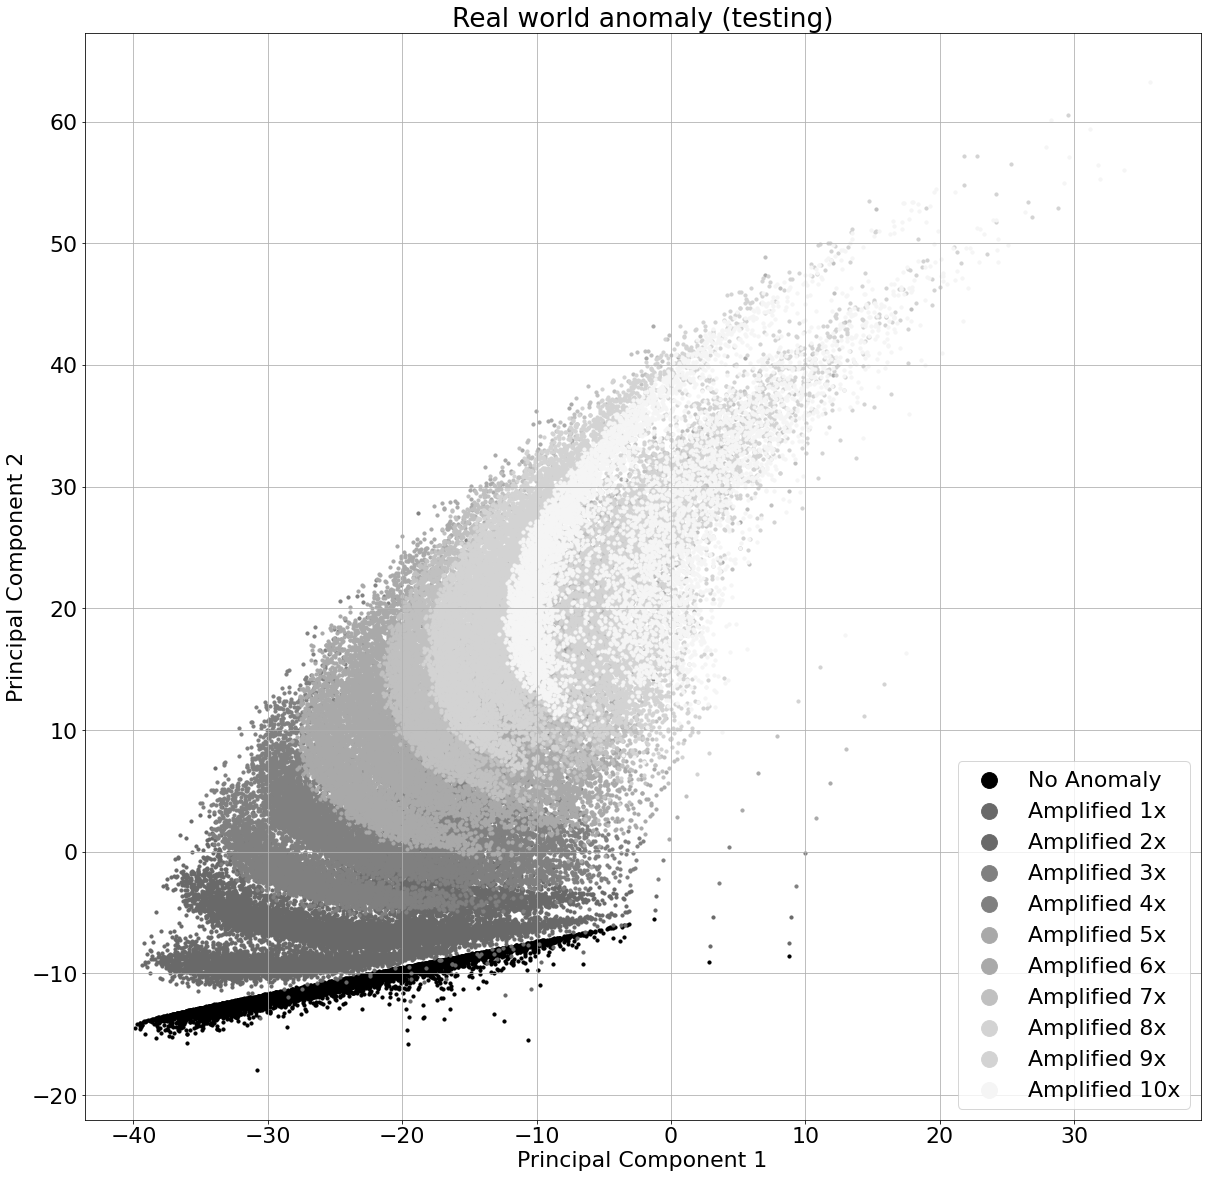

In [28]:
plt.rcParams.update({'legend.loc': 'lower right'})
plt.rcParams.update({'legend.markerscale': 5})
plt.rcParams.update({'legend.fontsize': 'medium'})
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Real world anomaly (testing)')
targets = [0.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,710.0]
# targets = ['TP','TN','FP','FN']
# colors = ['r', 'g', 'r','g']
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100','#ABA100']
colors = ['r', 'b','c','y','lawngreen','fuchsia','palegreen','deepskyblue','lightpink','mediumspringgreen','deeppink']
colors = ['k','dimgrey','dimgray','grey','gray','darkgray','darkgrey','silver','lightgrey','lightgray','whitesmoke']
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100','#AAA200','#AFA300','#FAF400','#FBC500','#8FA600','#1FA700','#2FA800','#F6A900','#00A510']
for target, color in zip(targets,colors):
    size = 10
#     if target==0.0:
#         size=100
    indicesToKeep = df_pcs_fsx_filtered['target'] == target
    scatter = ax.scatter(df_pcs_fsx_filtered.loc[indicesToKeep, 'pc1']
               , df_pcs_fsx_filtered.loc[indicesToKeep, 'pc2']
               , c = color
               , s = size)
ax.legend(['No Anomaly',
           'Amplified 1x',
           'Amplified 2x',
           'Amplified 3x',
           'Amplified 4x',
           'Amplified 5x',
           'Amplified 6x',
           'Amplified 7x',
           'Amplified 8x',
           'Amplified 9x',
           'Amplified 10x'
          ])
ax.grid()

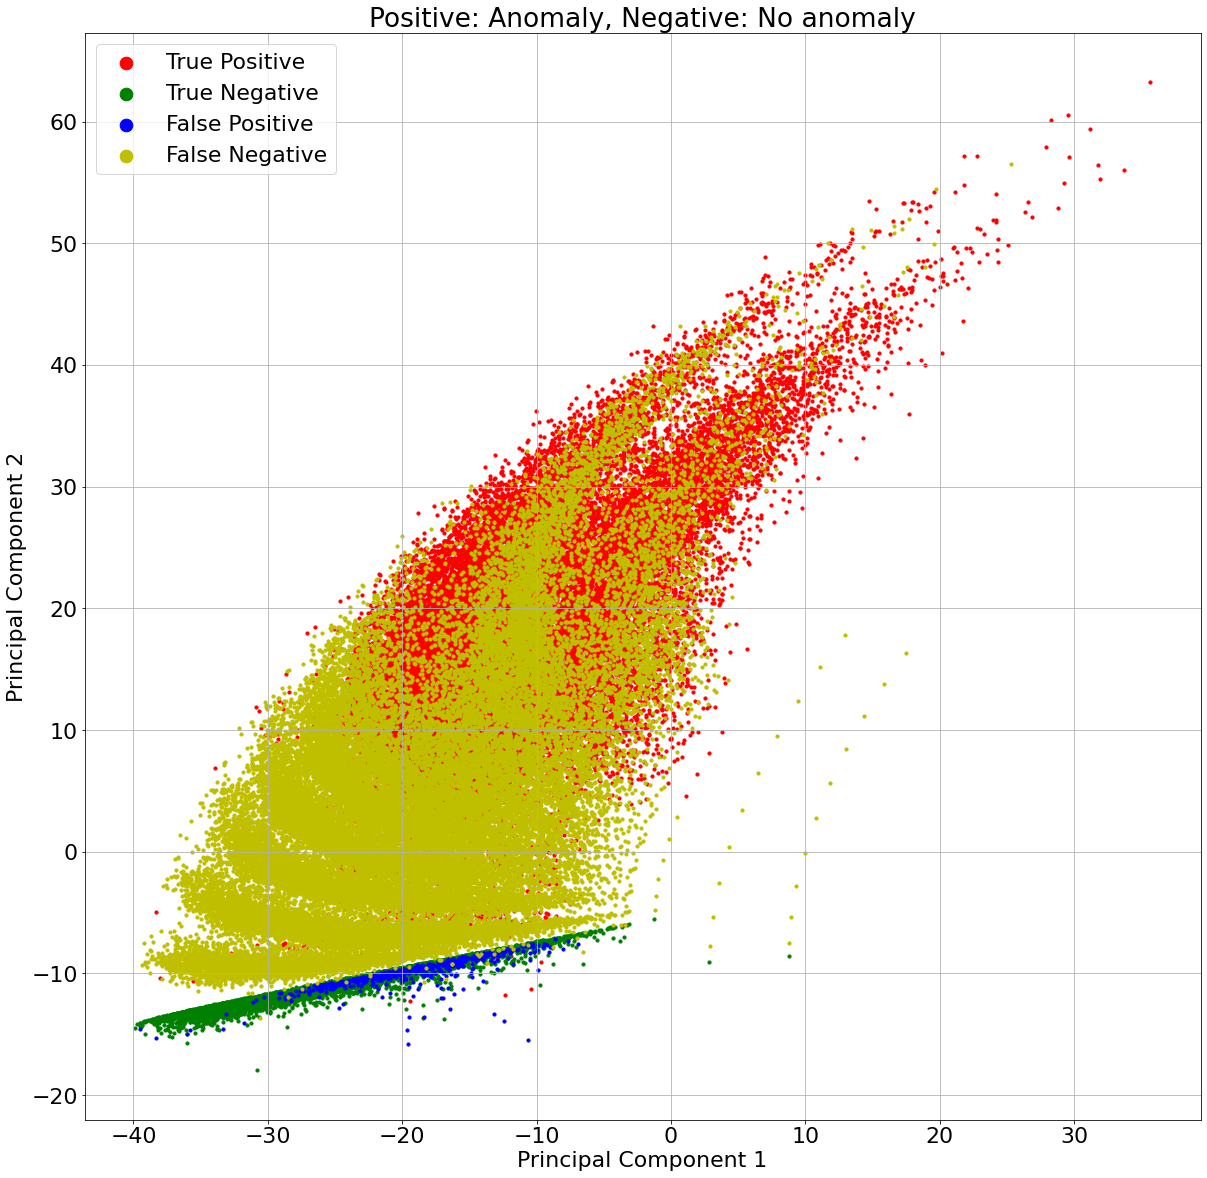

In [29]:
fig = plt.figure(figsize = (20,20))
plt.rcParams.update({'legend.markerscale': 4})
plt.rcParams.update({'legend.loc': 'upper left'})
plt.rcParams.update({'legend.fontsize': 'medium'})
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Positive: Anomaly, Negative: No anomaly')
# targets = sorted(list(pd.Series(labels).value_counts().index))
targets = ['TP','TN','FP','FN']
colors = ['r', 'g', 'b','y']
# colors = []
# for i in range(len(targets)):
#     colors.append(cmap(i))
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100']
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100','#AAA200','#AFA300','#FAF400','#FBC500','#8FA600','#1FA700','#2FA800','#F6A900','#00A510']
for target, color in zip(targets,colors):
    size = 10
#     if target in ['TP','FN']:
#         size=200
    indicesToKeep = df_pcs_fsx_filtered['prediction'] == target
    ax.scatter(df_pcs_fsx_filtered.loc[indicesToKeep, 'pc1']
               , df_pcs_fsx_filtered.loc[indicesToKeep, 'pc2']
               , c = color
               , s = size)
ax.legend(['True Positive', 'True Negative', 'False Positive', 'False Negative'])
ax.grid()

In [49]:
pca1 = PCA(n_components=2)

In [50]:
pcs_fsx = pca1.fit_transform(d_xs)
df_pcs_fsx = pd.DataFrame(data = pcs_fsx, columns = ['pc1', 'pc2'])
df_pcs_fsx = pd.concat([df_pcs_fsx, pd.Series(labels)], axis = 1)
df_pcs_fsx.columns = ['pc1','pc2','target']
df_pcs_fsx = pd.concat([df_pcs_fsx, pd.Series(scores)], axis = 1)
df_pcs_fsx.columns = ['pc1','pc2','target','score']

In [55]:
for index, row in df_pcs_fsx.iterrows():
    if row['target'] in [1.0,2.0,4.0,5.0,6.0]:
#     if row['target'] in [71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,710.0]:
        if row['score']>=threshold:
            df_pcs_fsx.loc[index,'prediction'] = 'TP'
        else:
            df_pcs_fsx.loc[index,'prediction'] = 'FN'
    elif row['target'] == 0.0:
        if row['score']>=threshold:
            df_pcs_fsx.loc[index,'prediction'] = 'FP'
        else:
            df_pcs_fsx.loc[index,'prediction'] = 'TN'

In [56]:
df_pcs_fsx_filtered = df_pcs_fsx

0        -38.615261
1        -36.018936
2        -33.898148
3        -38.663628
4        -33.866470
            ...    
124645   -22.342690
124646   -25.740517
124647   -24.567558
124648   -32.553326
124649    -7.029970
Name: pc1, Length: 7146, dtype: float32


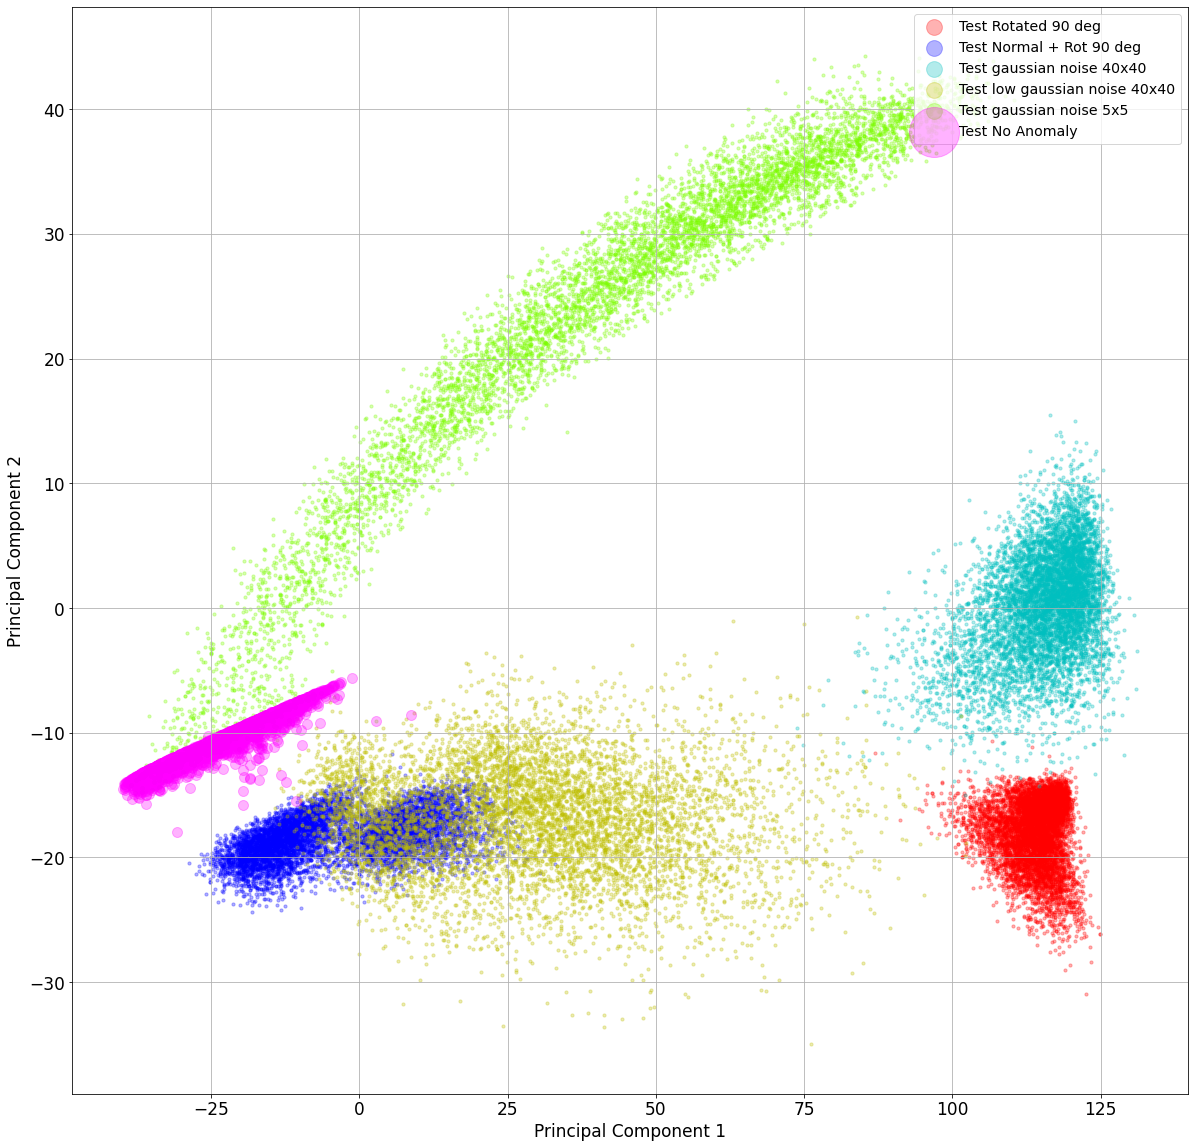

In [57]:
plt.rcParams.update({'legend.loc': 'upper right'})
plt.rcParams.update({'legend.markerscale': 5})
plt.rcParams.update({'legend.fontsize': 'small'})
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
# ax.set_title('2 component PCA')
targets = [1.0,2.0,4.0,5.0,6.0,0.0]
# targets = ['TP','TN','FP','FN']
# colors = ['r', 'g', 'r','g']
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100','#ABA100']
colors = ['r', 'b','c','y','lawngreen','fuchsia']
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100','#AAA200','#AFA300','#FAF400','#FBC500','#8FA600','#1FA700','#2FA800','#F6A900','#00A510']
for target, color in zip(targets,colors):
    size = 10
    if target==0.0:
        size=100
    indicesToKeep = df_pcs_fsx_filtered['target'] == target
    if target==0.0:
        print(df_pcs_fsx_filtered.loc[indicesToKeep, 'pc1'])
    scatter = ax.scatter(df_pcs_fsx_filtered.loc[indicesToKeep, 'pc1']
               , df_pcs_fsx_filtered.loc[indicesToKeep, 'pc2']
               , c = color
               , s = size, alpha=0.3)
ax.legend([
'Test Rotated 90 deg',
'Test Normal + Rot 90 deg',
           'Test gaussian noise 40x40','Test low gaussian noise 40x40','Test gaussian noise 5x5','Test No Anomaly'
          ])
ax.grid()



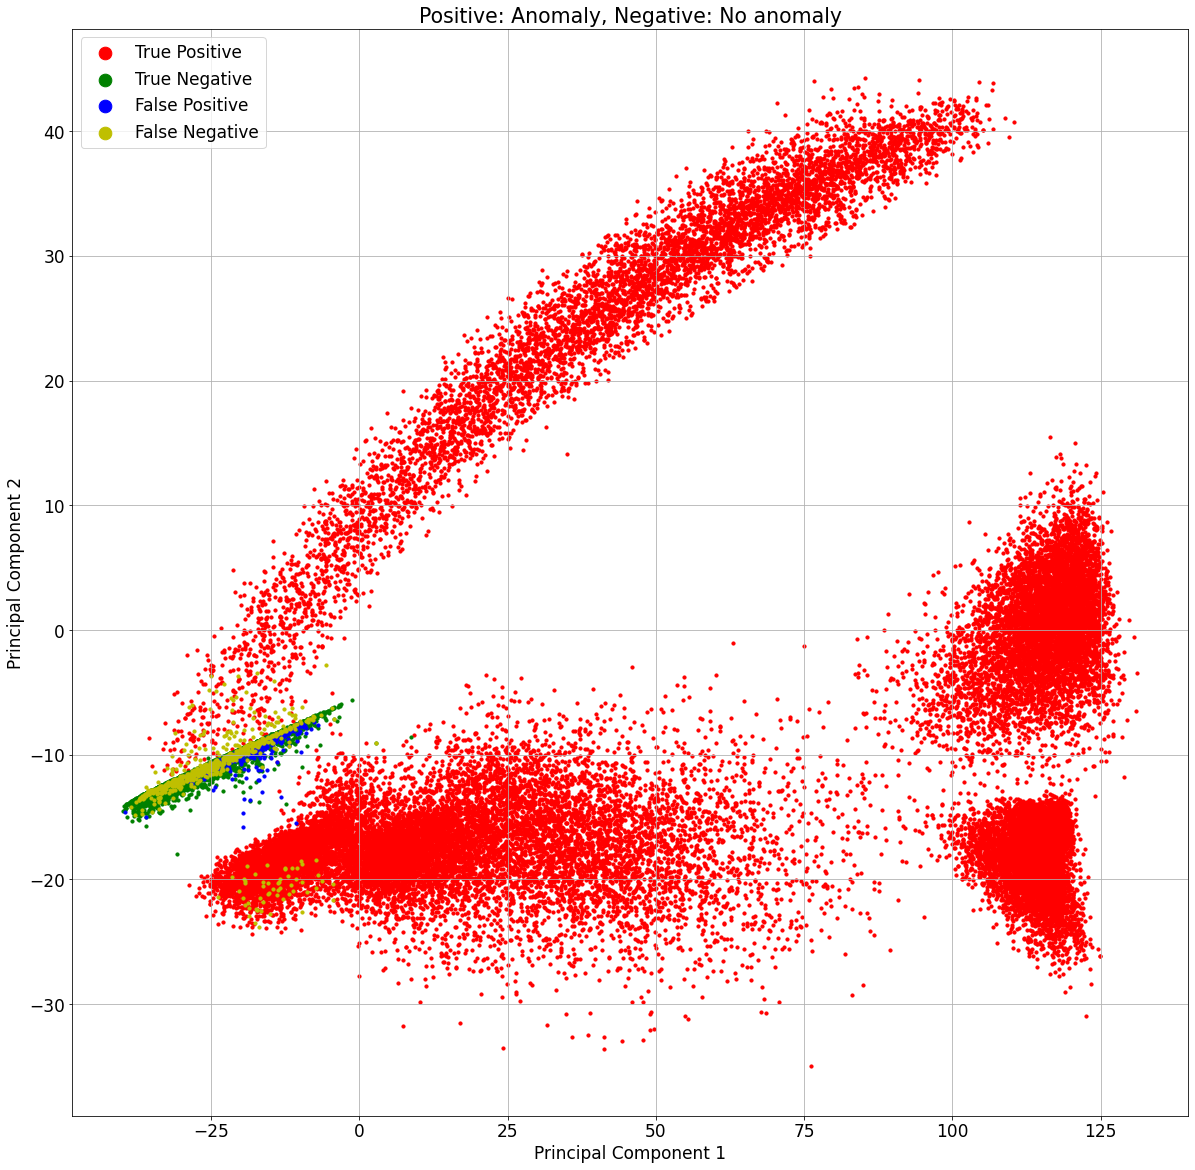

In [58]:
fig = plt.figure(figsize = (20,20))
plt.rcParams.update({'legend.markerscale': 4})
plt.rcParams.update({'legend.loc': 'upper left'})
plt.rcParams.update({'legend.fontsize': 'medium'})
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Positive: Anomaly, Negative: No anomaly')
# targets = sorted(list(pd.Series(labels).value_counts().index))
targets = ['TP','TN','FP','FN']
colors = ['r', 'g', 'b','y']
# colors = []
# for i in range(len(targets)):
#     colors.append(cmap(i))
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100']
# colors = ['r', 'g', 'b','c','m','y','k','#FAA100','#AAA200','#AFA300','#FAF400','#FBC500','#8FA600','#1FA700','#2FA800','#F6A900','#00A510']
for target, color in zip(targets,colors):
    size = 10
#     if target in ['TP','FN']:
#         size=200
    indicesToKeep = df_pcs_fsx_filtered['prediction'] == target
    ax.scatter(df_pcs_fsx_filtered.loc[indicesToKeep, 'pc1']
               , df_pcs_fsx_filtered.loc[indicesToKeep, 'pc2']
               , c = color
               , s = size)
ax.legend(['True Positive', 'True Negative', 'False Positive', 'False Negative'])
ax.grid()

Text(0.5, 1.0, 'Real world anomaly')

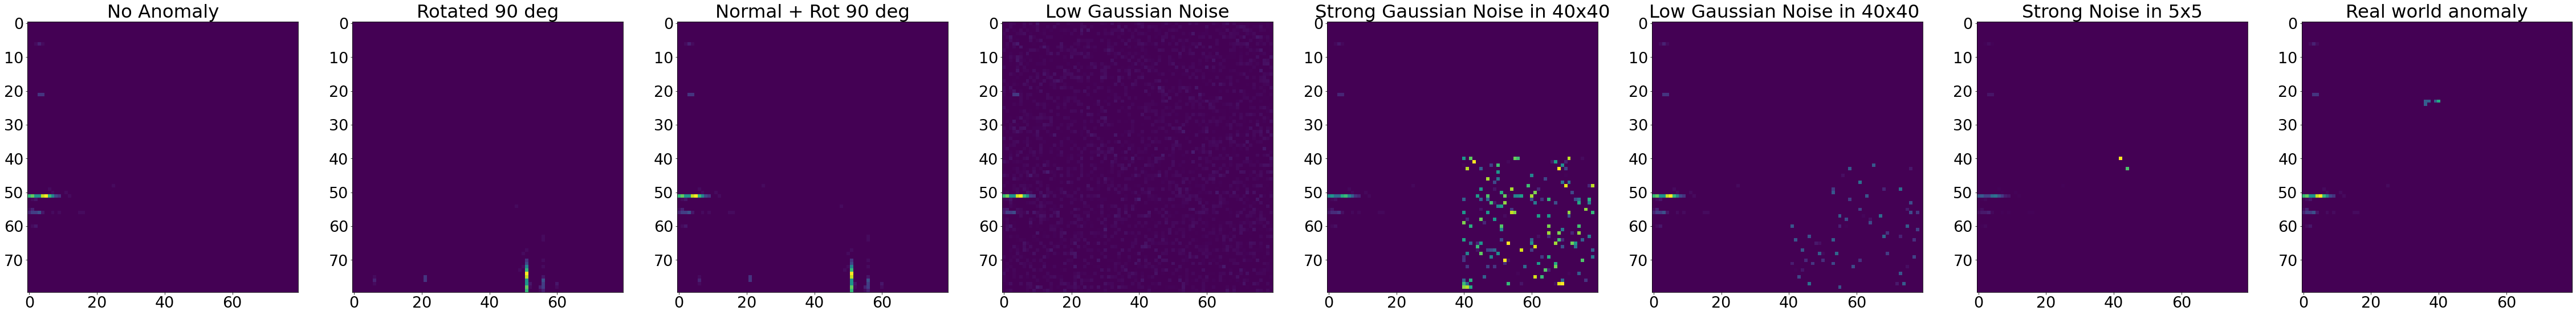

In [36]:
plt.rcParams.update({'font.size': 27})

fig,ax = plt.subplots(1,8,figsize=(80,10))
ax[0].imshow(dataBatchX.cpu().data.numpy()[-1,0])
ax[0].set_title('No Anomaly')
ax[1].imshow(anom1BatchX.cpu().data.numpy()[-1,0])
ax[1].set_title('Rotated 90 deg')
ax[2].imshow(anom2BatchX.cpu().data.numpy()[-1,0])
ax[2].set_title('Normal + Rot 90 deg')
ax[3].imshow(anom3BatchX.cpu().data.numpy()[-1,0])
ax[3].set_title('Low Gaussian Noise')
ax[4].imshow(anom4BatchX.cpu().data.numpy()[-1,0])
ax[4].set_title('Strong Gaussian Noise in 40x40')
ax[5].imshow(anom5BatchX.cpu().data.numpy()[-1,0])
ax[5].set_title('Low Gaussian Noise in 40x40 ')
ax[6].imshow(anom6BatchX.cpu().data.numpy()[-1,0])
ax[6].set_title('Strong Noise in 5x5')
ax[7].imshow(realanom10_BatchX.cpu().data.numpy()[-1,0])
ax[7].set_title('Real world anomaly')

In [37]:
testdata_scores_labels = [(testdata[i],scores[i],labels[i]) for i in range(len(scores))]

In [38]:
with open(outpath + '/scores/testdata_scores_labels_{}.pkl'.format(str(datetime.date.today())),'wb') as f:
    pickle.dump(testdata_scores_labels,f)

In [39]:
data_noanom = [x[0] for x in testdata_scores_labels if (x[2]==0)]
data_anom1 = [x[0] for x in testdata_scores_labels if (x[2]==1)]
data_anom2 = [x[0] for x in testdata_scores_labels if (x[2]==2)]
data_anom3 = [x[0] for x in testdata_scores_labels if (x[2]==3)]
data_anom4 = [x[0] for x in testdata_scores_labels if (x[2]==4)]
data_anom5 = [x[0] for x in testdata_scores_labels if (x[2]==5)]
data_anom6 = [x[0] for x in testdata_scores_labels if (x[2]==6)]
data_anom71 = [x[0] for x in testdata_scores_labels if (x[2]==71)]
data_anom72 = [x[0] for x in testdata_scores_labels if (x[2]==72)]
data_anom73 = [x[0] for x in testdata_scores_labels if (x[2]==73)]
data_anom74 = [x[0] for x in testdata_scores_labels if (x[2]==74)]
data_anom75 = [x[0] for x in testdata_scores_labels if (x[2]==75)]
data_anom76 = [x[0] for x in testdata_scores_labels if (x[2]==76)]
data_anom77 = [x[0] for x in testdata_scores_labels if (x[2]==77)]
data_anom78 = [x[0] for x in testdata_scores_labels if (x[2]==78)]
data_anom79 = [x[0] for x in testdata_scores_labels if (x[2]==79)]
data_anom710 = [x[0] for x in testdata_scores_labels if (x[2]==710)]

In [40]:
scores_noanom = [x[1] for x in testdata_scores_labels if (x[2]==0)]
scores_anom1 = [x[1] for x in testdata_scores_labels if (x[2]==1)]
scores_anom2 = [x[1] for x in testdata_scores_labels if (x[2]==2)]
scores_anom3 = [x[1] for x in testdata_scores_labels if (x[2]==3)]
scores_anom4 = [x[1] for x in testdata_scores_labels if (x[2]==4)]
scores_anom5 = [x[1] for x in testdata_scores_labels if (x[2]==5)]
scores_anom6 = [x[1] for x in testdata_scores_labels if (x[2]==6)]
scores_anom71 = [x[1] for x in testdata_scores_labels if (x[2]==71)]
scores_anom72 = [x[1] for x in testdata_scores_labels if (x[2]==72)]
scores_anom73 = [x[1] for x in testdata_scores_labels if (x[2]==73)]
scores_anom74 = [x[1] for x in testdata_scores_labels if (x[2]==74)]
scores_anom75 = [x[1] for x in testdata_scores_labels if (x[2]==75)]
scores_anom76 = [x[1] for x in testdata_scores_labels if (x[2]==76)]
scores_anom77 = [x[1] for x in testdata_scores_labels if (x[2]==77)]
scores_anom78 = [x[1] for x in testdata_scores_labels if (x[2]==78)]
scores_anom79 = [x[1] for x in testdata_scores_labels if (x[2]==79)]
scores_anom710 = [x[1] for x in testdata_scores_labels if (x[2]==710)]

In [41]:
preds = np.array([1 if s>threshold else 0 for s in scores_noanom])
preds_anom1 = np.array([1 if s>threshold else 0 for s in scores_anom1])
preds_anom2 = np.array([1 if s>threshold else 0 for s in scores_anom2])
preds_anom3 = np.array([1 if s>threshold else 0 for s in scores_anom3])
preds_anom4 = np.array([1 if s>threshold else 0 for s in scores_anom4])
preds_anom5 = np.array([1 if s>threshold else 0 for s in scores_anom5])
preds_anom6 = np.array([1 if s>threshold else 0 for s in scores_anom6])
preds_anom71 = np.array([1 if s>threshold else 0 for s in scores_anom71])
preds_anom72 = np.array([1 if s>threshold else 0 for s in scores_anom72])
preds_anom73 = np.array([1 if s>threshold else 0 for s in scores_anom73])
preds_anom74 = np.array([1 if s>threshold else 0 for s in scores_anom74])
preds_anom75 = np.array([1 if s>threshold else 0 for s in scores_anom75])
preds_anom76 = np.array([1 if s>threshold else 0 for s in scores_anom76])
preds_anom77 = np.array([1 if s>threshold else 0 for s in scores_anom77])
preds_anom78 = np.array([1 if s>threshold else 0 for s in scores_anom78])
preds_anom79 = np.array([1 if s>threshold else 0 for s in scores_anom79])
preds_anom710 = np.array([1 if s>threshold else 0 for s in scores_anom710])

Text(0.5, 1.0, 'KDE plot of anomaly scores')

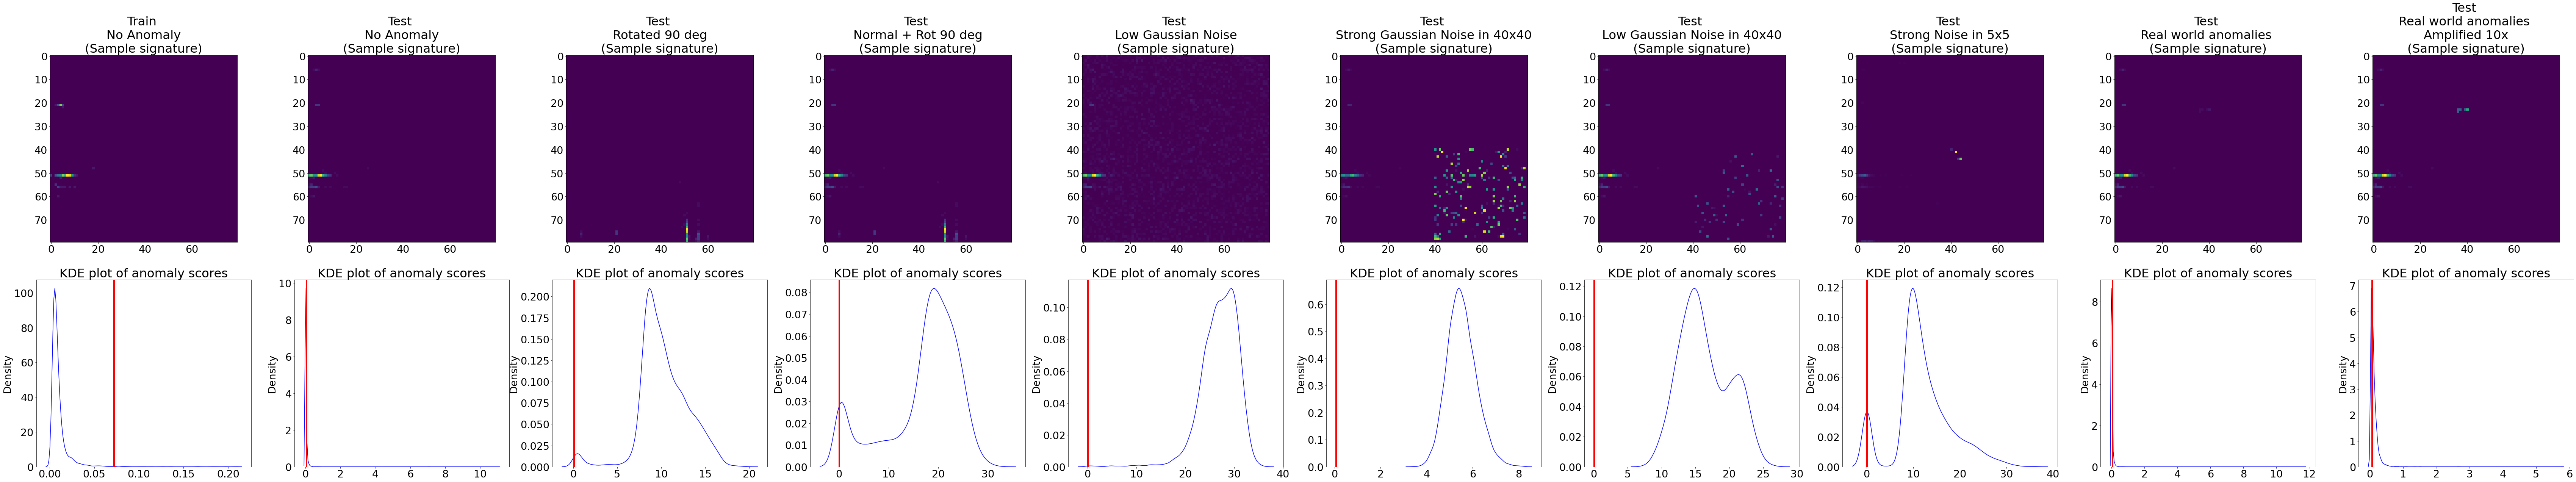

In [42]:
plt.rcParams.update({'font.size': 27})

fig,ax=plt.subplots(2,10,figsize=(120,20))

sns.kdeplot(np.array(val_scores),color='b',label="",ax = ax[1][0])
sns.kdeplot(np.array(scores_noanom),color='b',label="",ax = ax[1][1])
sns.kdeplot(np.array(scores_anom1),color='b',label="",ax = ax[1][2])
sns.kdeplot(np.array(scores_anom2),color='b',label="",ax = ax[1][3])
sns.kdeplot(np.array(scores_anom3),color='b',label="",ax = ax[1][4])
sns.kdeplot(np.array(scores_anom4),color='b',label="",ax = ax[1][5])
sns.kdeplot(np.array(scores_anom5),color='b',label="",ax = ax[1][6])
sns.kdeplot(np.array(scores_anom6),color='b',label="",ax = ax[1][7])
sns.kdeplot(np.array(scores_anom71),color='b',label="",ax = ax[1][8])
sns.kdeplot(np.array(scores_anom710),color='b',label="",ax = ax[1][9])

for i in range(10):
    ax[1][i].axvline(x=threshold,linewidth=4, color='r')

ax[0][0].imshow(train[100,0,:])
ax[0][1].imshow(data_noanom[-1])
ax[0][2].imshow(data_anom1[-1])
ax[0][3].imshow(data_anom2[-1])
ax[0][4].imshow(data_anom3[-1])
ax[0][5].imshow(data_anom4[-1])
ax[0][6].imshow(data_anom5[-1])
ax[0][7].imshow(data_anom6[-100])
ax[0][8].imshow(data_anom71[-1])
ax[0][9].imshow(data_anom710[-1])

ax[0][0].set_title('Train \nNo Anomaly\n(Sample signature)')
ax[0][1].set_title('Test \nNo Anomaly\n(Sample signature)')
ax[0][2].set_title('Test \nRotated 90 deg\n(Sample signature)')
ax[0][3].set_title('Test \nNormal + Rot 90 deg\n(Sample signature)')
ax[0][4].set_title('Test \nLow Gaussian Noise\n(Sample signature)')
ax[0][5].set_title('Test \nStrong Gaussian Noise in 40x40\n(Sample signature)')
ax[0][6].set_title('Test \nLow Gaussian Noise in 40x40\n(Sample signature)')
ax[0][7].set_title('Test \nStrong Noise in 5x5\n(Sample signature)')
ax[0][8].set_title('Test \nReal world anomalies \n(Sample signature)')
ax[0][9].set_title('Test \nReal world anomalies \nAmplified 10x\n(Sample signature)')

ax[1][0].set_title('KDE plot of anomaly scores')
ax[1][1].set_title('KDE plot of anomaly scores')
ax[1][2].set_title('KDE plot of anomaly scores')
ax[1][3].set_title('KDE plot of anomaly scores')
ax[1][4].set_title('KDE plot of anomaly scores')
ax[1][5].set_title('KDE plot of anomaly scores')
ax[1][6].set_title('KDE plot of anomaly scores')
ax[1][7].set_title('KDE plot of anomaly scores')
ax[1][8].set_title('KDE plot of anomaly scores')
ax[1][9].set_title('KDE plot of anomaly scores')

# plt.savefig(outpath + '/eval/kdepots_{}_izif.png'.format(str(datetime.date.today())))

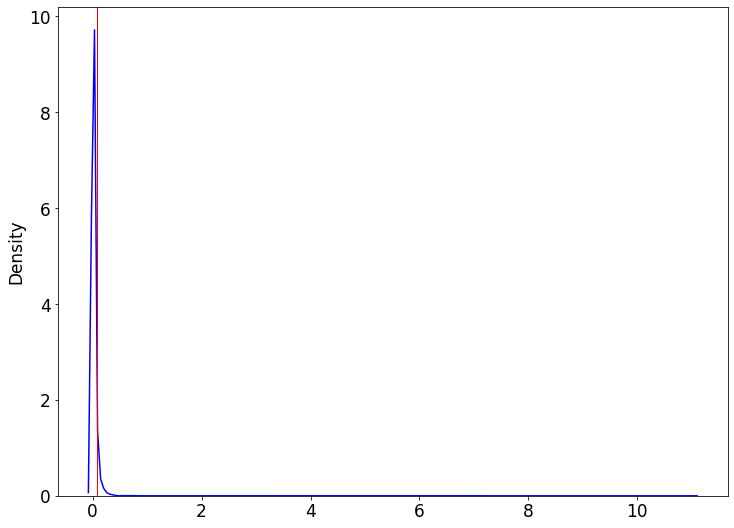

In [46]:
fig,ax=plt.subplots(1,1,figsize=(12,9))
sns.kdeplot(np.array(scores_noanom),color='b',label="")
ax.axvline(x=threshold*1.1,linewidth=1, color='r')

In [44]:
target_noanom = np.zeros(preds.shape)
target_anom = np.ones(preds.shape)

print('****')
print("Rotated 90 deg \n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom1]),target_names=['benign','anomaly']))
print('****')
print("Normal + Rot 90 deg \n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom2]),target_names=['benign','anomaly']))
print('****')
print("Low Gaussian Noise \n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom3]),target_names=['benign','anomaly']))
print('****')
print("Strong Gaussian Noise in 40x40 area \n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom4]),target_names=['benign','anomaly']))
print('****')
print("Low Gaussian Noise in 40x40 area \n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom5]),target_names=['benign','anomaly']))
print('****')
print("Strong Noise in 5x5 area \n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom6]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 1x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom71]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 2x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom72]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 3x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom73]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 4x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom74]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 5x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom75]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 6x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom76]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 7x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom77]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 8x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom78]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 9x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom79]),target_names=['benign','anomaly']))
print('****')
print("Real world anomaly 10x\n",classification_report(np.concatenate([target_noanom,target_anom]),np.concatenate([preds,preds_anom710]),target_names=['benign','anomaly']))

****
Rotated 90 deg 
               precision    recall  f1-score   support

      benign       1.00      0.93      0.96      7146
     anomaly       0.93      1.00      0.97      7146

    accuracy                           0.96     14292
   macro avg       0.97      0.96      0.96     14292
weighted avg       0.97      0.96      0.96     14292

****
Normal + Rot 90 deg 
               precision    recall  f1-score   support

      benign       0.99      0.93      0.96      7146
     anomaly       0.93      0.99      0.96      7146

    accuracy                           0.96     14292
   macro avg       0.96      0.96      0.96     14292
weighted avg       0.96      0.96      0.96     14292

****
Low Gaussian Noise 
               precision    recall  f1-score   support

      benign       1.00      0.93      0.96      7146
     anomaly       0.93      1.00      0.97      7146

    accuracy                           0.96     14292
   macro avg       0.97      0.96      0.96     14292

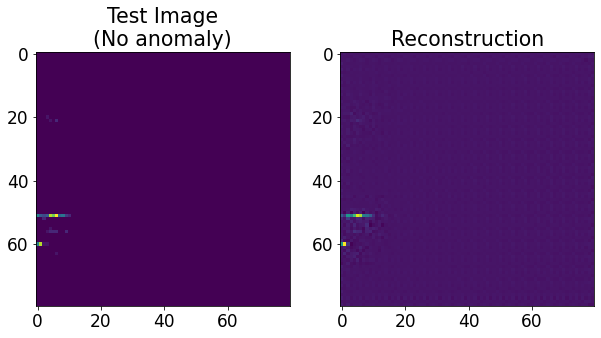

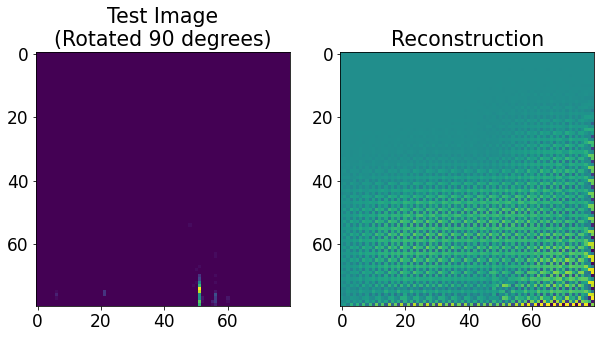

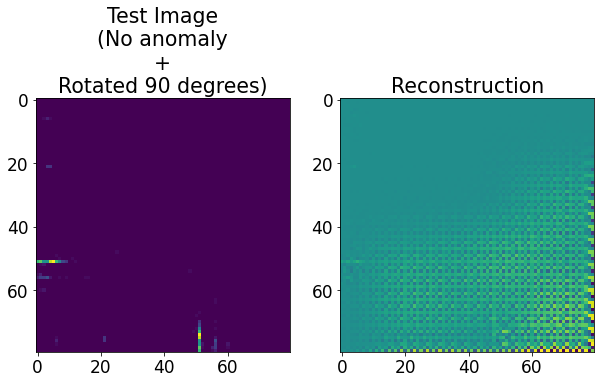

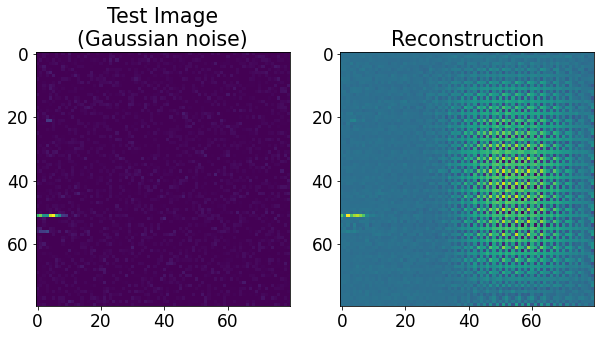

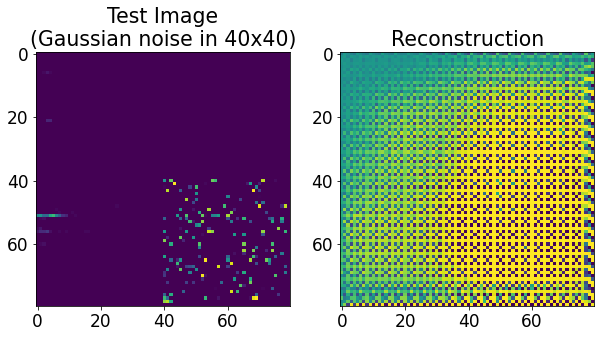

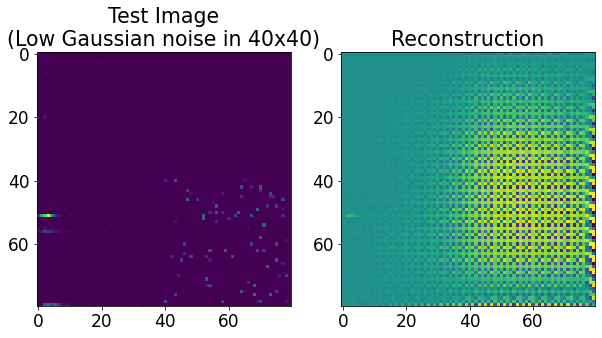

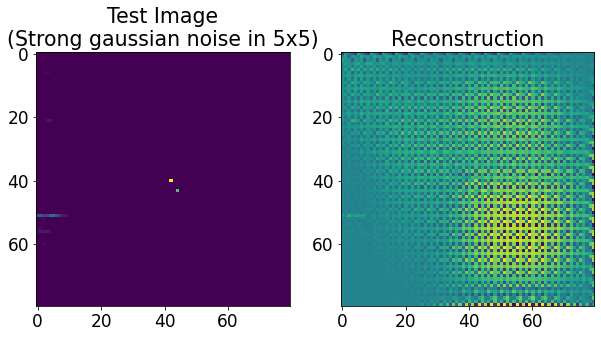

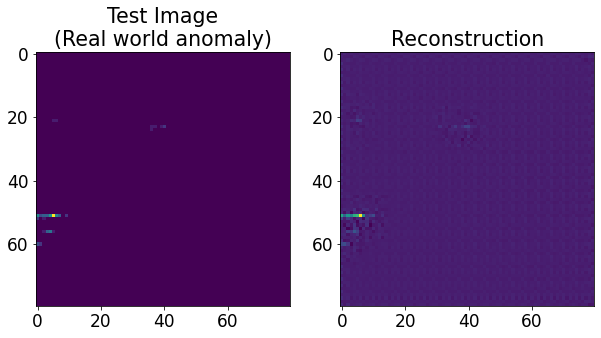

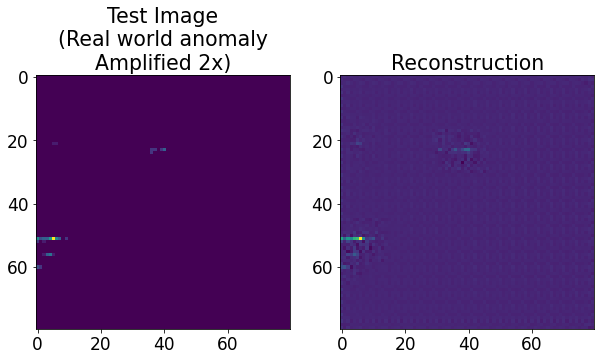

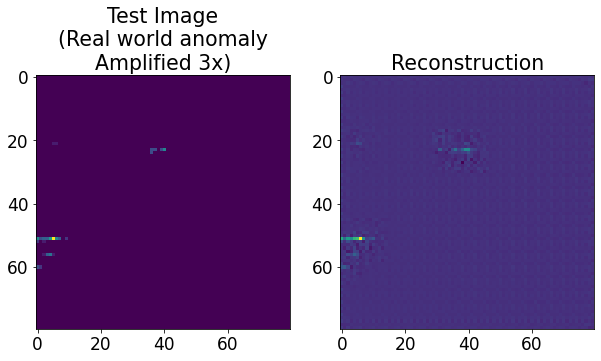

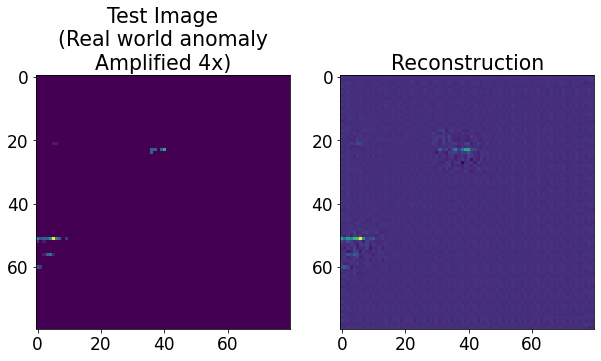

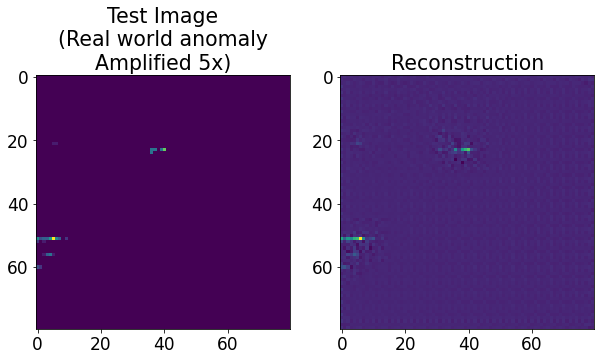

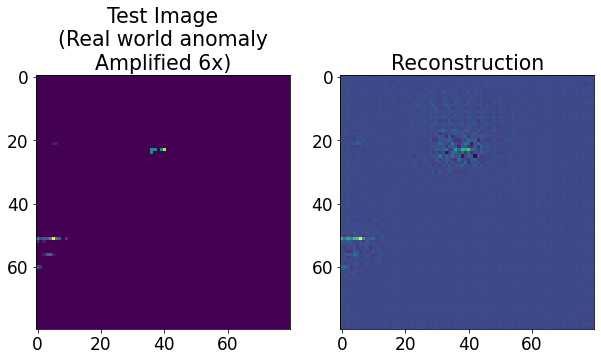

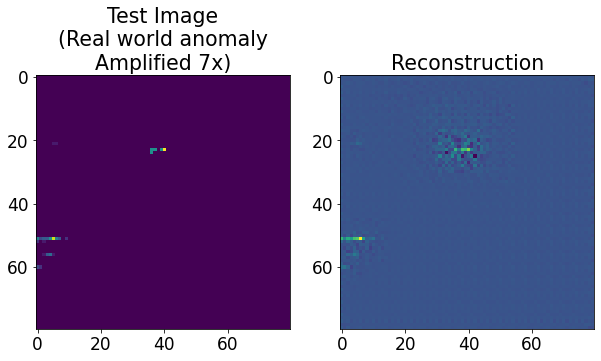

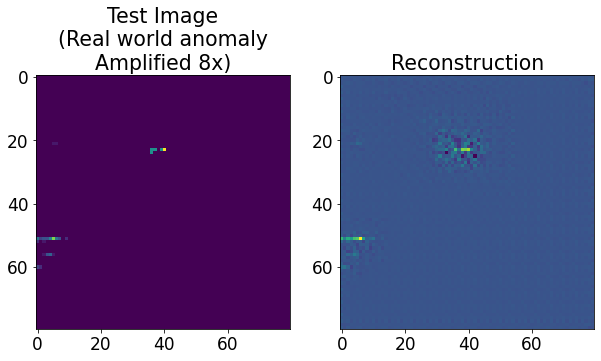

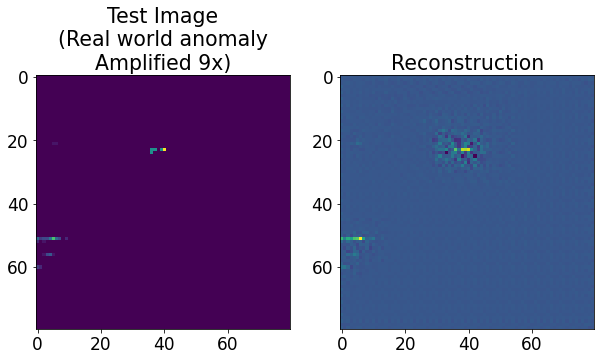

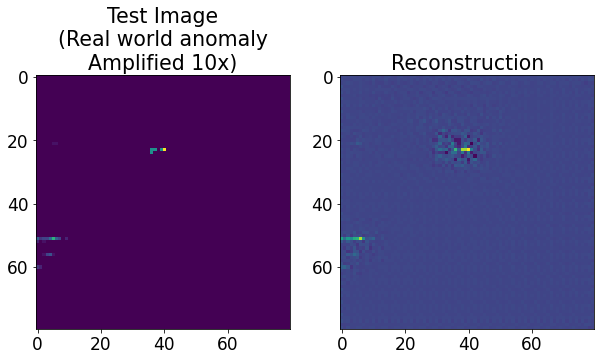

In [45]:
plt.rcParams.update({'font.size': 17})

for idx,data in enumerate([data_noanom[200],data_anom1[-1],data_anom2[-1],data_anom3[-1],data_anom4[-1],data_anom5[-100],data_anom6[-1],data_anom71[1],data_anom72[1],data_anom73[1],data_anom74[1],data_anom75[1],data_anom76[1],data_anom77[1],data_anom78[1],data_anom79[1],data_anom710[1]]):

    rec_image = netG(torch.randn(1,1, 10, 10, device=device),torch.tensor(data).to(device).unsqueeze(0).unsqueeze(0)).cpu().data.numpy()

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[1].imshow(rec_image[0,0])
    ax[0].imshow(data)
    if idx==0:
        ax[0].set_title('Test Image\n(No anomaly)')
        ax[1].set_title('Reconstruction') 
    elif idx==1:
        ax[0].set_title('Test Image\n(Rotated 90 degrees)')
        ax[1].set_title('Reconstruction')
    elif idx==2:
        ax[0].set_title('Test Image\n(No anomaly\n+\nRotated 90 degrees)')
        ax[1].set_title('Reconstruction')
    elif idx==3:
        ax[0].set_title('Test Image\n(Gaussian noise)')
        ax[1].set_title('Reconstruction')
    elif idx==4:
        ax[0].set_title('Test Image\n(Gaussian noise in 40x40)')
        ax[1].set_title('Reconstruction')
    elif idx==5:
        ax[0].set_title('Test Image\n(Low Gaussian noise in 40x40)')
        ax[1].set_title('Reconstruction')
    elif idx==6:
        ax[0].set_title('Test Image\n(Strong gaussian noise in 5x5)')
        ax[1].set_title('Reconstruction')
    elif idx==7:
        ax[0].set_title('Test Image\n(Real world anomaly)')
        ax[1].set_title('Reconstruction')
    elif idx==8:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 2x)')
        ax[1].set_title('Reconstruction')
    elif idx==9:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 3x)')
        ax[1].set_title('Reconstruction')
    elif idx==10:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 4x)')
        ax[1].set_title('Reconstruction')
    elif idx==11:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 5x)')
        ax[1].set_title('Reconstruction')
    elif idx==12:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 6x)')
        ax[1].set_title('Reconstruction')
    elif idx==13:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 7x)')
        ax[1].set_title('Reconstruction')
    elif idx==14:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 8x)')
        ax[1].set_title('Reconstruction')
    elif idx==15:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 9x)')
        ax[1].set_title('Reconstruction')
    elif idx==16:
        ax[0].set_title('Test Image\n(Real world anomaly\nAmplified 10x)')
        ax[1].set_title('Reconstruction')